## Population analysis and forecasting

In [438]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set()

In [439]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from typing import List, Iterable
from datetime import timedelta

### Load  the Data



> Source: [link to kaggle dataset](https://www.kaggle.com/datasets/census/population-time-series-data?resource=download)



In [440]:
data = pd.read_csv('/content/drive/MyDrive/DataSets/PopulationPrediction/POP.csv')

In [441]:
# data = pd.read_csv('/content/drive/MyDrive/DataSets/PopulationPrediction/POP.csv',
#                    index_col = 'date',
#                    parse_dates = True)

### About Dataset



> This is a dataset from the U.S. Census Bureau hosted by the Federal Reserve Economic Database (FRED). 



### Data Preprocessing

In [442]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   realtime_start  816 non-null    object 
 1   value           816 non-null    float64
 2   date            816 non-null    object 
 3   realtime_end    816 non-null    object 
dtypes: float64(1), object(3)
memory usage: 25.6+ KB


In [443]:
data.realtime_end

0      2019-12-06
1      2019-12-06
2      2019-12-06
3      2019-12-06
4      2019-12-06
          ...    
811    2019-12-06
812    2019-12-06
813    2019-12-06
814    2019-12-06
815    2019-12-06
Name: realtime_end, Length: 816, dtype: object

In [444]:
data.shape

(816, 4)

In [445]:
data.date.unique().size

816

In [446]:
data.drop(['realtime_start', 'realtime_end'], axis = 1, inplace = True)

In [447]:
data.set_index('date', inplace = True)

In [448]:
data.index = pd.to_datetime(data.index)

In [449]:
data.index

DatetimeIndex(['1952-01-01', '1952-02-01', '1952-03-01', '1952-04-01',
               '1952-05-01', '1952-06-01', '1952-07-01', '1952-08-01',
               '1952-09-01', '1952-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=816, freq=None)

### Exploratory Data Analysis

In [450]:
data.resample(rule = 'AS').mean()

,value
date,
1952-01-01,157492.583333
1953-01-01,160146.166667
1954-01-01,162968.250000
1955-01-01,165872.333333
1956-01-01,168857.666667
...,...
2015-01-01,320929.533083
2016-01-01,323224.626667
2017-01-01,325326.015500


In [451]:
data.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [452]:
data.shift(3, axis = 0).head()

,value
date,
1952-01-01,NaN
1952-02-01,NaN
1952-03-01,NaN
1952-04-01,156309.0
1952-05-01,156527.0


In [453]:
data.rolling(window = 3).mean()

,value
date,
1952-01-01,NaN
1952-02-01,NaN
1952-03-01,156522.333333
1952-04-01,156733.666667
1952-05-01,156938.000000
...,...
2019-08-01,329400.105000
2019-09-01,329590.732667
2019-10-01,329786.413333


In [454]:
data['1952-01' : '1952-05']

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [455]:
data.iloc[:5,:]

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0




> Data Visualisation



[Text(0, 0.5, 'Population'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Population from 1952 to 2019')]

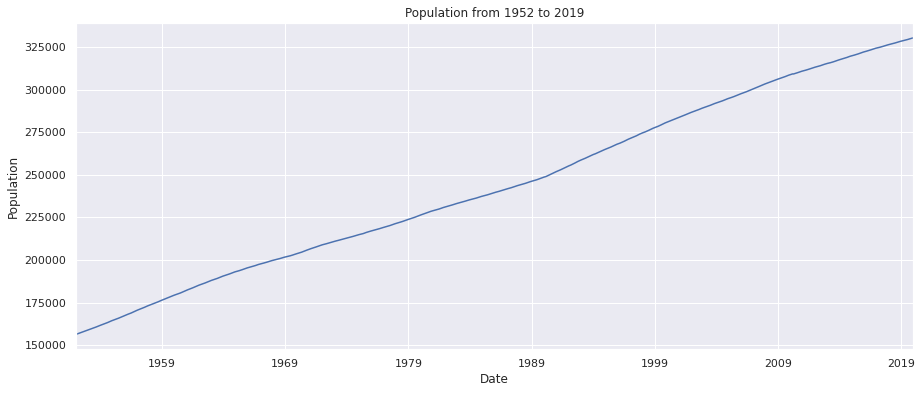

In [456]:
# plt.style.use('ggplot')

ax = data.plot(figsize = (15, 6), legend = None)
ax.set(title = 'Population from 1952 to 2019', xlabel = 'Date', ylabel = 'Population')

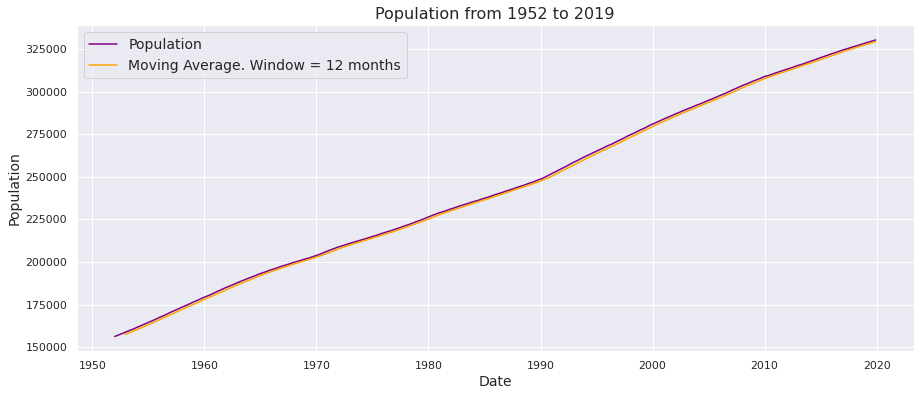

In [457]:
plt.figure(figsize = (15,6))

plt.plot(data, label = 'Population', color = 'purple')
plt.plot(data.rolling(window = 12).mean(), label = 'Moving Average. Window = 12 months', color = 'orange')

plt.xlabel('Date', fontsize = 14)
plt.ylabel('Population', fontsize = 14)
plt.title('Population from 1952 to 2019', fontsize = 16)
plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.show()



#### Autocorrelation



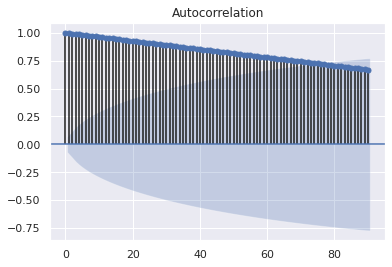

In [458]:
plot_acf(data, lags = 90)
plt.show()

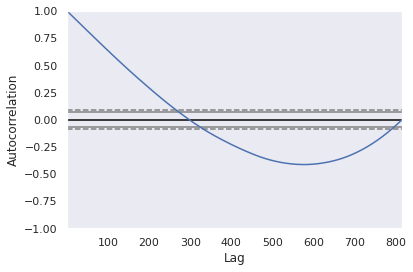

In [459]:
pd.plotting.autocorrelation_plot(data['value'])



#### Stationarity Checking



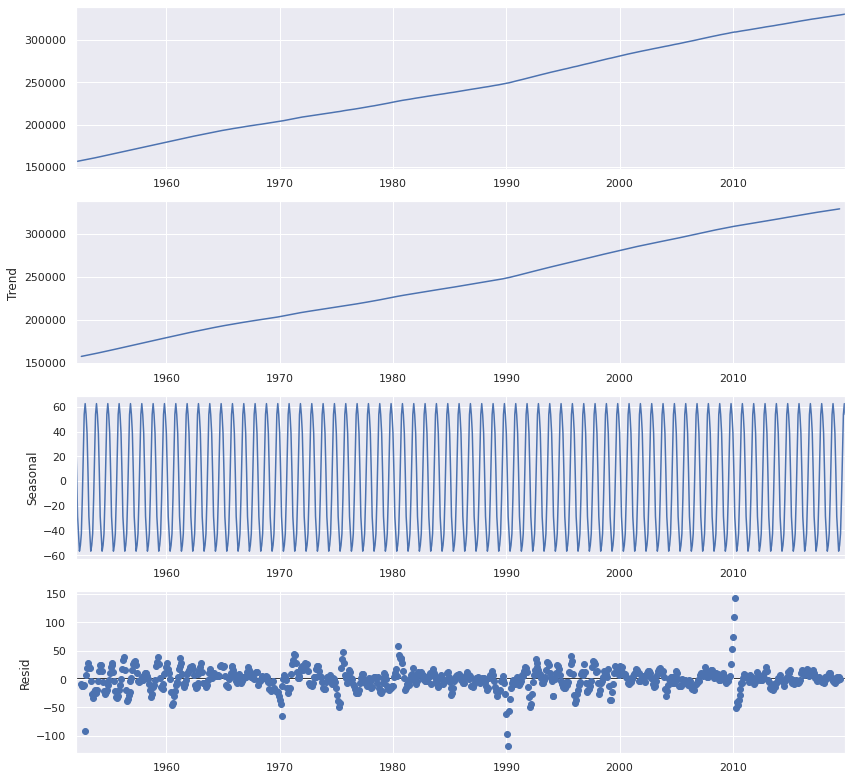

In [460]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 12, 11

decompose = seasonal_decompose(data)
decompose.plot()

plt.show()


There is an uptrend



> Dickey - Fuller Test



In [461]:
from statsmodels.tsa.stattools import adfuller

# H0 - non-stationary
# H1 - stationary

def to_check_stationarity(data : Iterable):

    alpha = 0.05

    adf_test = adfuller(x = data) 
    p_value = adf_test[1]

    if p_value > alpha: print(f'alpha = {alpha}' + '\n' +
                              f'p-value = {p_value}')
    
    else: print(f'alpha = {alpha}' + '\n' +
                f'p-value = {p_value}')

In [462]:
to_check_stationarity(data['value'])

alpha = 0.05
p-value = 0.8555297778919719




> The statistical test showed that the series is non - stationary. This can also be seen in the graph above



### Modeling and forecasting

In [463]:
# горизонт прогнозирования
horizon_ = 48

In [464]:
# train, test split

train = data['value'][:-horizon_]
test = data['value'].drop(train.index)

In [465]:
plot_data_slice = data['value']['2014':]

#### Exponential smoothing(EMA)

In [466]:
ema_fit = ExponentialSmoothing(train, trend = 'additive', damped_trend = True).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [467]:
# prediction
ema_fc = ema_fit.predict(len(train), len(train) + horizon_ - 1)

In [468]:
ema_fc

2016-01-01    322227.016022
2016-02-01    322405.031287
2016-03-01    322577.927255
2016-04-01    322745.851146
2016-05-01    322908.945945
2016-06-01    323067.350525
2016-07-01    323221.199766
2016-08-01    323370.624668
2016-09-01    323515.752465
2016-10-01    323656.706731
2016-11-01    323793.607488
2016-12-01    323926.571304
2017-01-01    324055.711396
2017-02-01    324181.137727
2017-03-01    324302.957094
2017-04-01    324421.273225
2017-05-01    324536.186866
2017-06-01    324647.795864
2017-07-01    324756.195252
2017-08-01    324861.477331
2017-09-01    324963.731747
2017-10-01    325063.045570
2017-11-01    325159.503363
2017-12-01    325253.187259
2018-01-01    325344.177029
2018-02-01    325432.550149
2018-03-01    325518.381868
2018-04-01    325601.745271
2018-05-01    325682.711341
2018-06-01    325761.349018
2018-07-01    325837.725263
2018-08-01    325911.905109
2018-09-01    325983.951718
2018-10-01    326053.926439
2018-11-01    326121.888852
2018-12-01    326187

In [469]:
# saving results

predictions = pd.DataFrame(test.copy())
predictions.rename(columns = {'value' : 'test'}, inplace = True)

predictions['EMA'] = ema_fc

In [470]:
predictions

,test,EMA
date,,
2016-01-01,322232.862,322227.016022
2016-02-01,322398.098,322405.031287
2016-03-01,322551.468,322577.927255
2016-04-01,322721.212,322745.851146
2016-05-01,322899.995,322908.945945
2016-06-01,323088.466,323067.350525
2016-07-01,323291.042,323221.199766
2016-08-01,323501.361,323370.624668
2016-09-01,323709.851,323515.752465


In [471]:
# own implementation
def EMA(data : Iterable, alpha : float) -> List[float]:

  exp_ma = [data[0]]

  for i in range(0, len(data)):
      exp_ma.append(round(alpha*data[i] + (1 - alpha)*exp_ma[i - 1], 2))

  return exp_ma


In [472]:
ema_ = EMA(data = data['value'], alpha = 0.2)

In [473]:
ema_[-1]

328939.54

In [474]:
len(ema_)

817

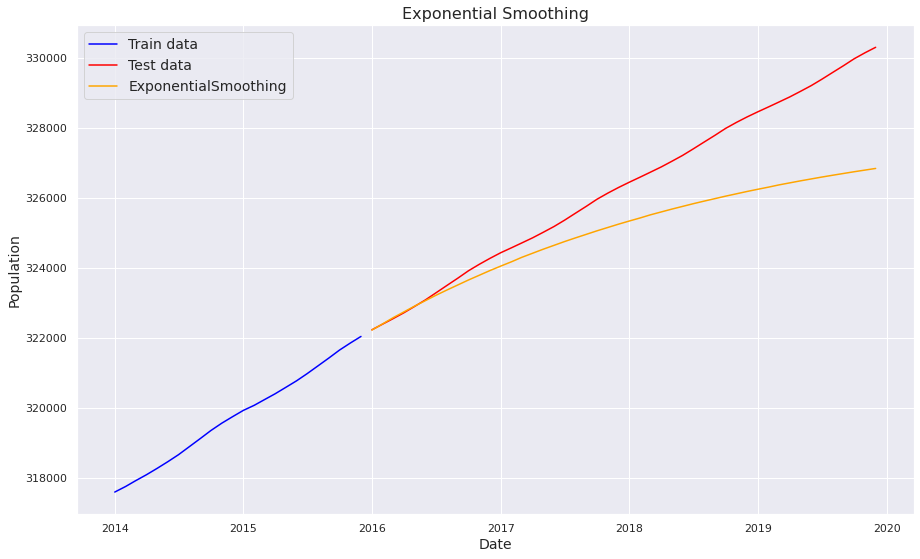

In [475]:
plt.figure(figsize = (15, 9))

plt.plot(train[train.isin(plot_data_slice)], color = 'blue', label = 'Train data')
plt.plot(test[test.isin(plot_data_slice)], color = 'red', label = 'Test data')
plt.plot(predictions['EMA'], color = 'orange', label = 'ExponentialSmoothing')

plt.xlabel('Date', fontsize = 14)
plt.ylabel('Population', fontsize = 14)
plt.legend(fontsize = 14)
plt.title('Exponential Smoothing', fontsize = 16)

plt.show()

#### ARIMA

##### Defining model's parameters: p, d, q

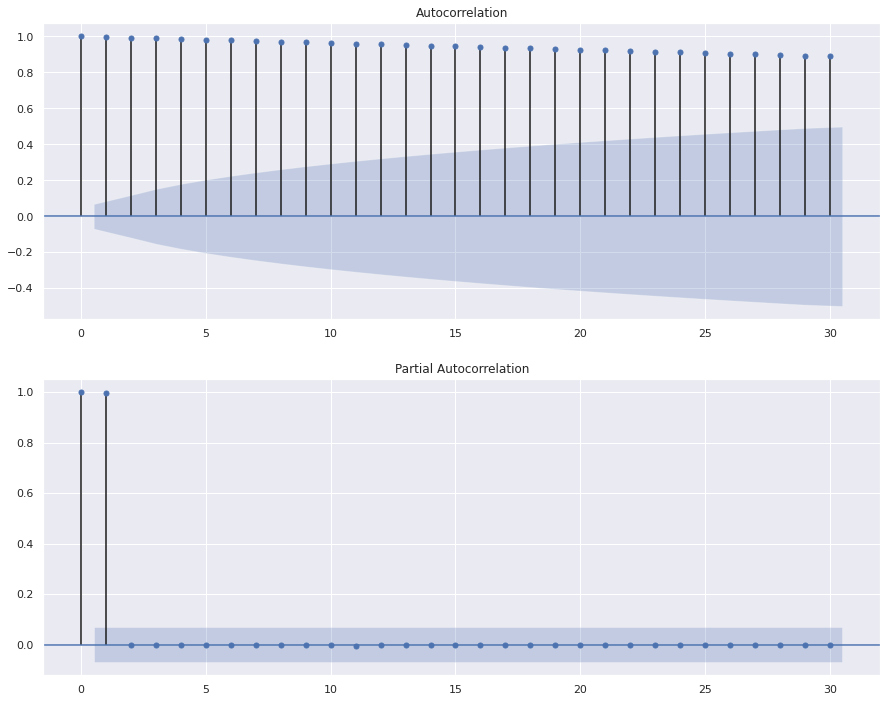

In [476]:
fig, ax = plt.subplots(2, 1, figsize = (15,12))

plot_acf(data['value'], ax = ax[0])
plot_pacf(data['value'], ax = ax[1])

plt.show()

Let's remove the trend in the data using **DS** (difference stationary method)



> 1st difference



In [477]:
data['stationary1'] = data['value'].diff()

In [478]:
to_check_stationarity(data['stationary1'].iloc[1:])

alpha = 0.05
p-value = 0.2822512276644472




> 2nd difference



In [479]:
data['stationary2'] = data['stationary1'].diff()

In [480]:
to_check_stationarity(data['stationary2'].iloc[2:])

alpha = 0.05
p-value = 2.1100121875843522e-10


The time-series becomes stationary at d = 2

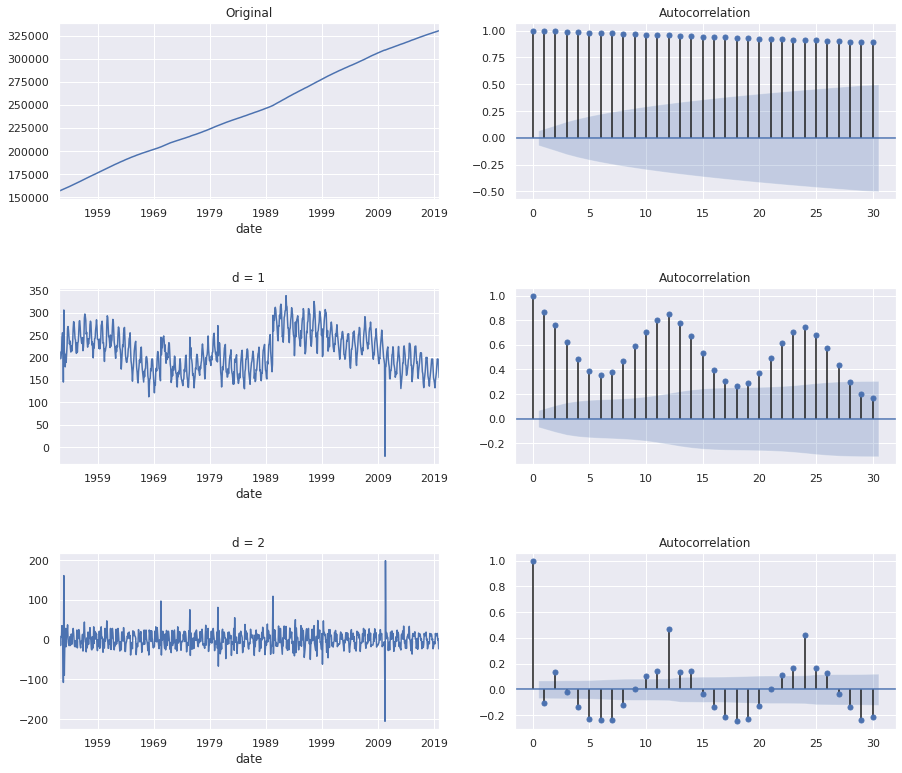

In [481]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 13))
plt.subplots_adjust(hspace = 0.5)

data['value'].plot(ax = axs[0, 0])
plot_acf(data['value'], ax = axs[0, 1])

data['stationary1'].plot(ax = axs[1, 0])
plot_acf(data['stationary1'].dropna(), ax = axs[1, 1])

data['stationary2'].plot(ax = axs[2, 0])
plot_acf(data['stationary2'].dropna(), ax = axs[2, 1])

axs[0, 0].set_title('Original')
axs[1, 0].set_title('d = 1')
axs[2, 0].set_title('d = 2')

plt.show()

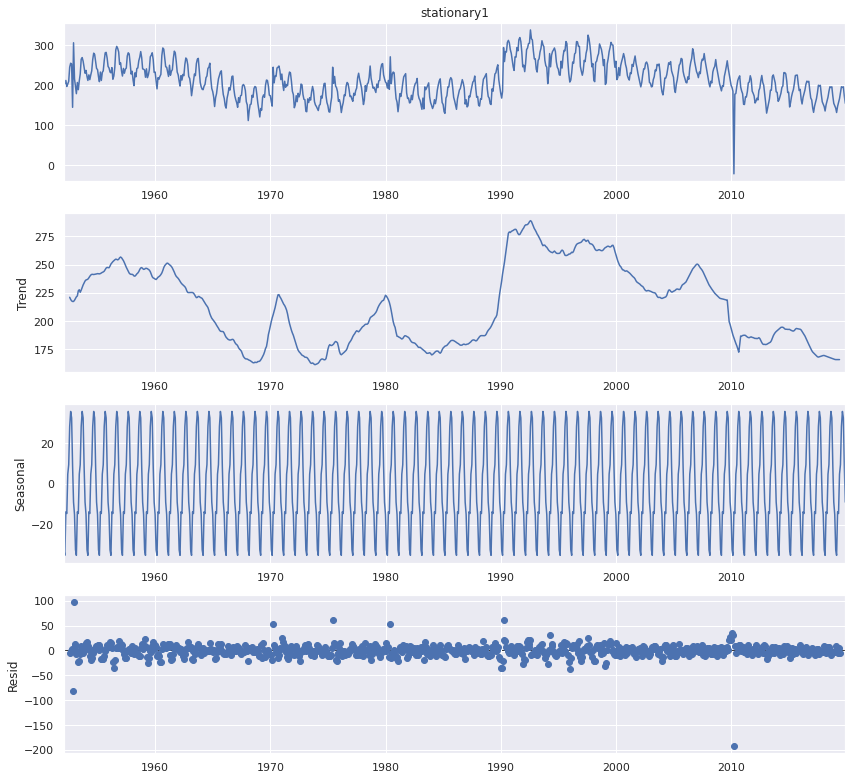

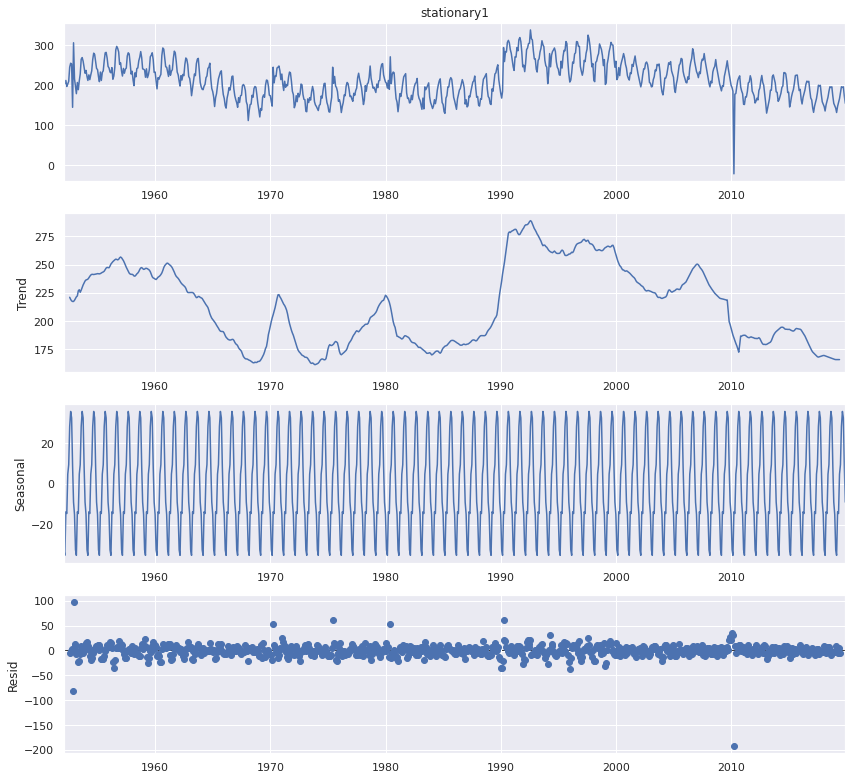

In [482]:
seasonal_decompose(data['stationary1'].dropna()).plot()

There are negative autocorrelations at d = 2, we will choose d = 1, despite the fact that the stationarity is not strong

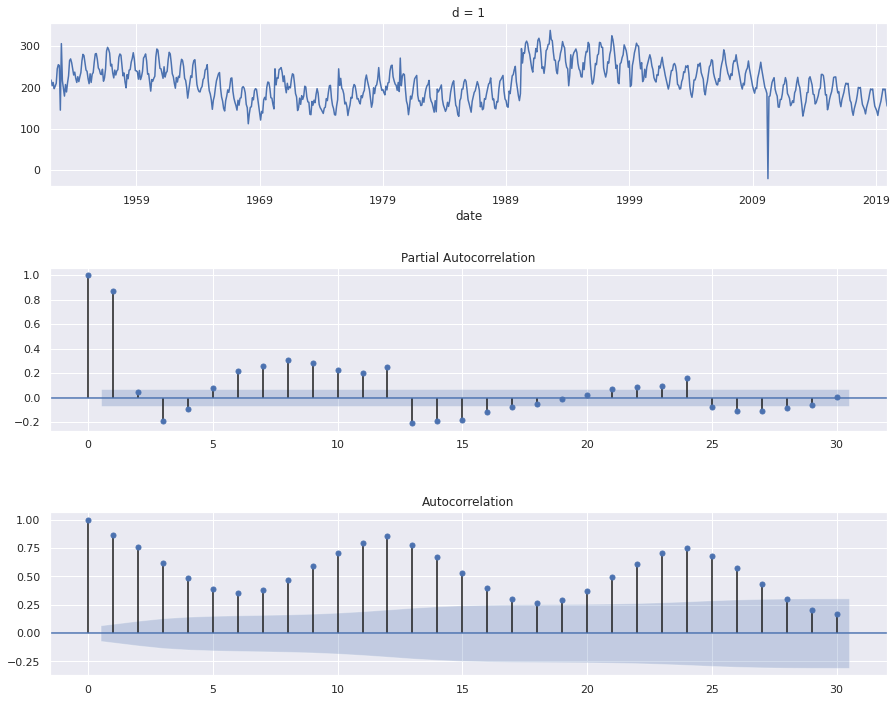

In [483]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 12))
plt.subplots_adjust(hspace = 0.5)

data['stationary1'].plot(ax = axs[0]); axs[0].set_title('d = 1')
plot_pacf(data['stationary1'].dropna(), ax = axs[1])
plot_acf(data['stationary1'].dropna(), ax = axs[2])

plt.show()

p = 1, q = 2

In [484]:
p, d, q = 1, 1, 2

##### Building a model and forecasts

In [485]:
arima_ = ARIMA(train, order = (p,d,q))
arima_fit_ = arima_.fit(disp = -1)

# arima_pred_ = arima_fit_.predict(start = len(train), end = len(train) + horizon_)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [486]:
print(arima_fit_.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  767
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3450.577
Method:                       css-mle   S.D. of innovations             21.734
Date:                Mon, 21 Nov 2022   AIC                           6911.154
Time:                        12:52:47   BIC                           6934.367
Sample:                    02-01-1952   HQIC                          6920.089
                         - 12-01-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           215.8513      5.302     40.713      0.000     205.460     226.243
ar.L1.D.value     0.8253      0.025     33.679      0.000       0.777       0.873
ma.L1.D.value    -0.0442      0.041     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


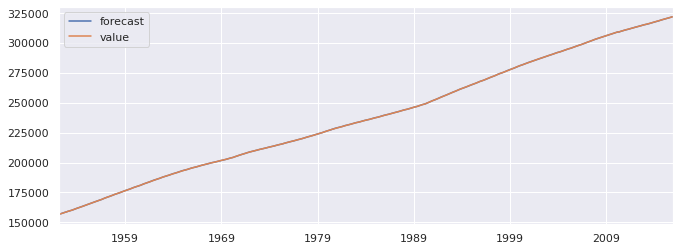

In [487]:
plt.rcParams.update({'figure.figsize':(11,4)})

arima_fit_.plot_predict(dynamic = False)

plt.show()

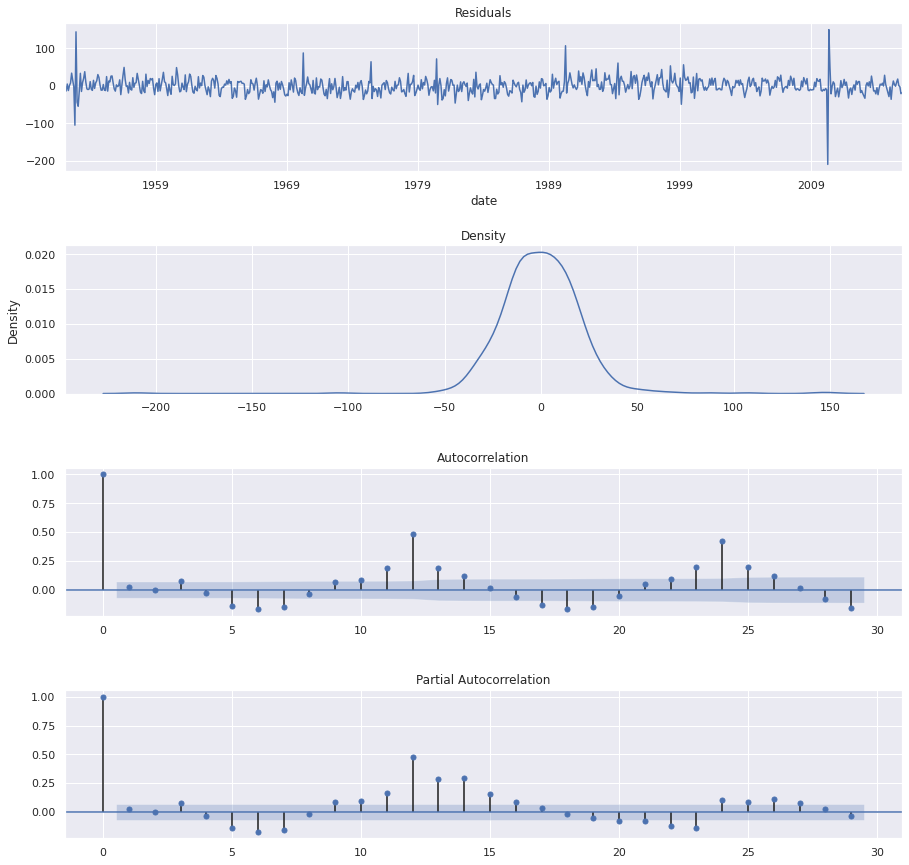

In [488]:
residuals = arima_fit_.resid

fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (15, 15))
plt.subplots_adjust(hspace = 0.5)

residuals.plot(ax = axs[0], title = 'Residuals')
sns.kdeplot(x = residuals, ax = axs[1]); axs[1].set(title = 'Density')

plot_acf(residuals, ax = axs[2])
plot_pacf(residuals, ax = axs[3])

plt.show()



> Building forecasts



In [489]:
arima_fc, se, conf = arima_fit_.forecast(horizon_)

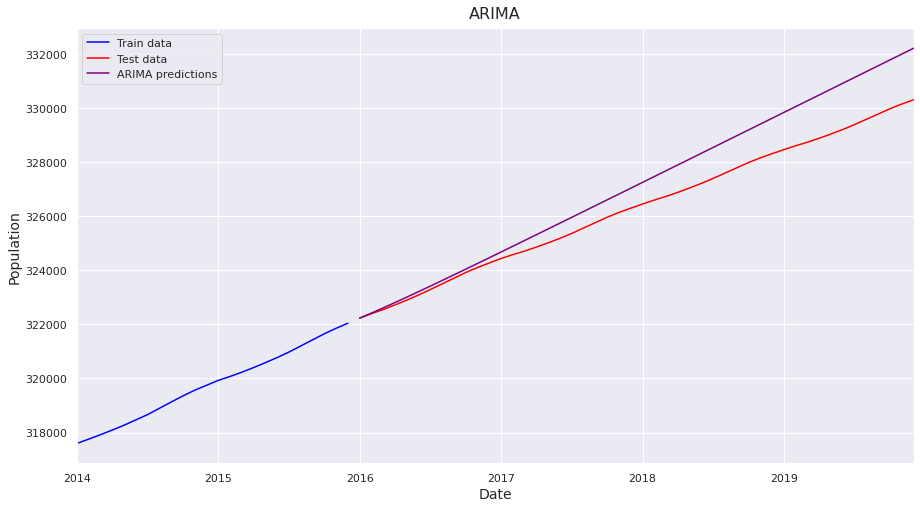

In [490]:
plt.figure(figsize = (15, 8))

train[train.isin(plot_data_slice)].plot(color = 'blue', label = 'Train data')
test[test.isin(plot_data_slice)].plot(color = 'red', label = 'Test data')
pd.Series(arima_fc, index = test.index).plot(color = 'purple', label = 'ARIMA predictions')

plt.title('ARIMA',  fontsize = 16, pad = 10.)
plt.ylabel('Population', fontsize = 14)
plt.xlabel('Date',  fontsize = 14)
plt.legend()

plt.show()

In [491]:
predictions[f'ARIMA({p,d,q})'] = arima_fc

In [492]:
predictions

,test,EMA,"ARIMA((1, 1, 2))"
date,,,
2016-01-01,322232.862,322227.016022,322230.958225
2016-02-01,322398.098,322405.031287,322419.315161
2016-03-01,322551.468,322577.927255,322612.475227
2016-04-01,322721.212,322745.851146,322809.599338
2016-05-01,322899.995,322908.945945,323009.994996
2016-06-01,323088.466,323067.350525,323213.090678
2016-07-01,323291.042,323221.199766,323418.414702
2016-08-01,323501.361,323370.624668,323625.577789
2016-09-01,323709.851,323515.752465,323834.258664


#### Hybrid

In [493]:
hybrid_forcasts = (predictions['EMA'] + predictions['ARIMA((1, 1, 2))']) / 2

In [494]:
predictions['Hybrid'] = hybrid_forcasts
predictions.head()

,test,EMA,"ARIMA((1, 1, 2))",Hybrid
date,,,,
2016-01-01,322232.862,322227.016022,322230.958225,322228.987124
2016-02-01,322398.098,322405.031287,322419.315161,322412.173224
2016-03-01,322551.468,322577.927255,322612.475227,322595.201241
2016-04-01,322721.212,322745.851146,322809.599338,322777.725242
2016-05-01,322899.995,322908.945945,323009.994996,322959.470470


#### EMA vs ARIMA vs Hybrid

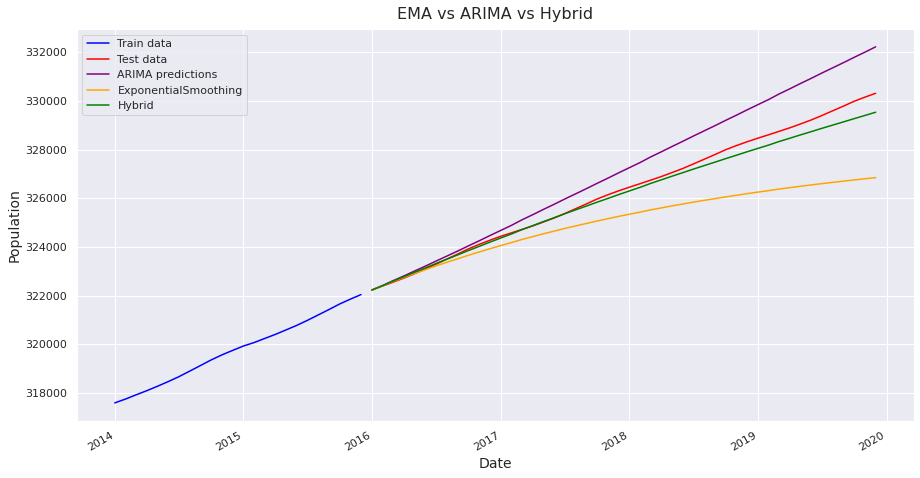

In [495]:
plt.figure(figsize = (15, 8))

plt.plot(train[train.isin(plot_data_slice)], color = 'blue', label = 'Train data')
plt.plot(test[test.isin(plot_data_slice)], color = 'red', label = 'Test data')
pd.Series(arima_fc, index = test.index).plot(color = 'purple', label = 'ARIMA predictions')
plt.plot(predictions['EMA'], color = 'orange', label = 'ExponentialSmoothing')
plt.plot(predictions['Hybrid'], color = 'green', label = 'Hybrid')

plt.title('EMA vs ARIMA vs Hybrid',  fontsize = 16, pad = 10.)
plt.ylabel('Population', fontsize = 14)
plt.xlabel('Date',  fontsize = 14)
plt.legend()

plt.show()



> MAPE (Mean Absolute Percentage Error)


In [496]:
MAPE_ema = np.mean(np.abs((predictions['EMA'].to_numpy() - predictions['test'].to_numpy()) / predictions['test'].to_numpy()))*100
MAPE_arima = np.mean(np.abs((predictions['ARIMA((1, 1, 2))'].to_numpy() - predictions['test'].to_numpy()) / predictions['test'].to_numpy()))*100
MAPE_hybrid = np.mean(np.abs((predictions['Hybrid'].to_numpy() - predictions['test'].to_numpy()) / predictions['test'].to_numpy()))*100

In [497]:
print(f'MAPE_ema = {MAPE_ema}' + '\n' +
      f'MAPE_ema = {MAPE_arima}' + '\n' +
      f'MAPE_ema = {MAPE_hybrid}')

MAPE_ema = 0.389311378255427
MAPE_ema = 0.25978314911416944
MAPE_ema = 0.06810417137147382




> The hybrid model has the least MAPE 

